# Overview
In this report, we present results of training two agents for the Tennis environment using the Deep Deterministic Policy Gradient (DDPG) algorithm, with noise reduction scheduling.

In [6]:
import pickle

import numpy as np
import matplotlib.pyplot as plt

# Read agent's scores to plot:
scores_train = pickle.load(open('weights_learned/scores_train.pkl','rb'))
scores_test = pickle.load(open('weights_learned/scores_test.pkl','rb'))
print(len(scores_train), len(scores_test))

3363 100


# Methods

## Deep Deterministic Policy Gradient (DDPG) Learning Algorithm
The Deep Deterministic Policy Gradient (DDPG) algorithm is an off-policy learning algorithm for continuous action space that simultaneously learns 1) Q-function and 2) policy. As was done for the DQN algorithm, it uses 1) Replay Buffer and 2) local vs target neural-networks to allow stable approximations of the optimal Q-function and policy.

Specifically, the Bellman equation is used to approximate the Q-function (i.e. "critic"). Here, neural-network parameters of the "critic" are optimized such that differences between target Q-function values and expected values are minimized.

Next, parameters of the local "actor" neural-network are optimized such that local version of the Q-function (i.e. local "critic"), which take actions from the "actor" neural-network yields maximum value.

Finally, target neural-networks for "actor" and "critic" are updated with their local counter parts, where update amount is determined by "tau".


## Implementation
The current implementation is a simple extension of the DDPG algorithm for two agents, where each agent gets a separate set of state, actions, reward, and next state.
In the notebook `training_code_tennis.ipynb`, function `ddpg_double()` implements the main loop that goes over episodes and trains two DDPG agents. For each episode, each agent gets its own state, makes an action via `agent.act()` and `env.step()` functions, gets rewards and next states information from the environment, and then the agent collects experiences and learns by calling the function `agent.step()`. The main loop ends when the agents have "solved" the environment, which is achieving average maximum score of 0.5+ during past 100 episodes.

As for details of the agent's implementations, they are provided in the `udacity` python package that is included with the training code notebook. Inside this package, file `ddpg_agent.py` implements the agent, and its "learn" function implements the DDPG learning algorithm described above. The file `model.py` implements "actor" and "critic" neural-networks. 

In terms of neural-network structures, both the "actor" and "critic" neural-networks use 2 hidden layers. For the "actor" neural-network structure, its layer sizes are "24->512->256->2", where you start with a batch of states, each with a size of 24. The state layer is then followed by 2 hidden layers of sizes 512 and 256, respectively, and the last layer's size is 2, which corresponds to moving toward / away from the net, and jumping. In terms of the "actor's" forward() function, a "BatchNorm1d" is ran on the input state so that input values are scaled to similar ranges, thereby improving learning. Outputs of the 2 hidden layers are fed through the "ReLu" non-linear activation functions, and finally to ensure action values are in range (-1, +1), output of last layer is fed to the tanh function.

The critic neural-network also has 4 layers with sizes "24->(512+2)->256->1", where you start with a batch of states, as was done for the "actor" neural-network. Howevever, for its 2nd layer, actions from the agent are incorporated along with outputs from the previous layer. The 2nd layer is then followed by a layer of size 256, and finally the last layer returns a real value for the estimated q-function value. For the "forward()" function, similar to the "actor" neural-network, BatchNorm1d is used on the input state. In addition, a dropout function is applied on the output of the 3rd layer (i.e. 2nd hidden layer), which randomly sets the layer's values to zeros with probability `p`. The dropout was used to act like a regularization to force the neural-network to learn something useful.

Lastly, hyper-parameters used in the training code are shown below. They are largely derived from those used in the DDPG algorithm paper (Lillicrap et al. 2015). For the replay buffer, its size was set to 1e6 with a batch size of 512. For the discount factor (i.e. gamma), a value of 0.99 was used. For the learning rates of actor and critic neural-networks, 1e-4 and 3e-4 were used, respectively. For the soft update, 1e-3 was used. For the learn step, the agent calls its learn() function every 4 steps so that convergence is stable. For its dropout function, probably of setting zeros of 0.2 was used. Lastly, in the `ddpg_double()` function a scheduling is employed where agents start with 2000 steps of random actions, followed by gradual decrease of amount of noise added to actions until maximum score over the two agents reaches 0.25. Using this scheduling led to reaching the required score threshold, and using 2000 steps initially for random actions led to faster reaching of the threshold.




| Hyper Parameter      | Value | Description |
| ----------- | ----------- | |
| Buffer Size      | 1e6       | Replay Buffer Size |
| Batch Size      | 512       | Size of each batch of experiences |
| Gamma      | 0.99       | Discount factor |
| Tau      | 1e-3       | Soft update parameter |
| Learning Rate Actor      | 1e-4       | Learning rate of actor network |
| Learning Rate Critic      | 3e-4       | Learning rate of critic network |
| Update Interval      | 4       | Frequency of network update|
| Dropout      | 0.2       | Probability of setting zeros|
| FC1      | 512      | 1st hidden layer size|
| FC2      | 256      | 2nd hidden layer size|
| STEPS_RANDOM      | 2000      | Number of initial time steps during which actions will be random|






# Results
In this section, we show results of training two DDPG agents in the Tennis environment as well as those from testing two new agents with the learned weights.

As you can see in Figure 1 for the training the two agents, over the course of ~3400 episodes, agentss score (i.e. maximum score over two agents per episode) starts at around 0, and gradually increase, followed by a sharp rise at the end, until the environment is solved at a score of 0.5. Based on the Reacher environment description, an average of 30+ during past 100 consecutive episodes indicates "solving" the environment. 

To ensure that the saved learned weights of the neural-network models representing "actor" and "critic" policy actually are from the learned agent, we created two new agents and loaded the weights and tested the agents in the environment. In Figure 2, we can see that the agents' scores are stable around 2.6, unlike the random agent (i.e. 0.02), still maintaining its ability to solve the environment. 


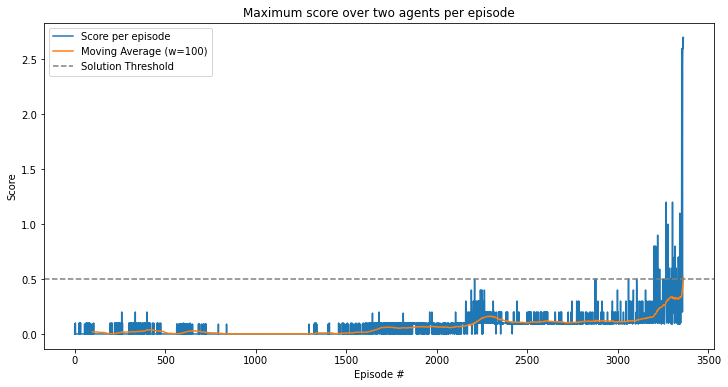

In [7]:
# Figure 1: This is a plot of final rewards over episodes during training the two agents:

# Moving average with window size of 100:
w = 100
scores_ma = np.convolve(scores_train, np.ones(w), 'valid') / w
idx = range(w-1, len(scores_train))

# plot the scores
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

plt.plot(scores_train, label='Score per episode')
plt.plot(idx, scores_ma, label='Moving Average (w=100)')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Maximum score over two agents per episode')
plt.axhline(y=0.5, color='gray', linestyle='--', label='Solution Threshold')
plt.legend()



Mean Score: 2.629000039175153


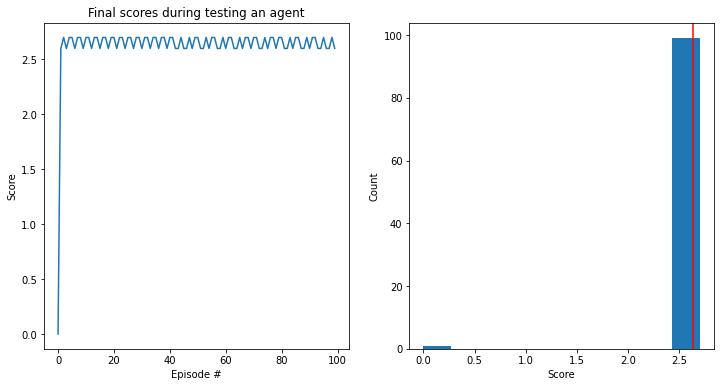

In [8]:
# Figure 2: This is a plot of rewards during testing of an agent that read learned weights from the previous training session:

fig = plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(np.arange(len(scores_test)), scores_test)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Final scores during testing an agent')

plt.subplot(1,2,2)
score_mean = np.mean(scores_test)
plt.hist(scores_test)
plt.ylabel('Count')
plt.xlabel('Score')
plt.axvline(x=score_mean, color='red')

print('Mean Score:', score_mean)

# Discussion
To improve the performance of the agent, we could try to improve the hyper-parameters. Specifically, we can either use random or grid-based approach to maximize performance of an agent as hyper-parameters are varied. We could also vary the schedule of noise added to agent's actions, since this proved to be very useful for the current implementation. Lastly, we could try algorithms such as MADDPG that were specifically developed for Multi-Agent usecase (Lowe 2017).




# References
1. [DDPG paper(Lillicrap TP et al. "Continuous control with deep reinforcement learning", 2015)](https://arxiv.org/abs/1509.02971)
2. [DDPG Algorithm Description, OpenAI](https://spinningup.openai.com/en/latest/algorithms/ddpg.html)
3. [Duan Y. et al. "Benchmarking Deep Reinforcement Learning for Continuous Control", 2016](http://proceedings.mlr.press/v48/duan16.pdf)
4. [Lowe R et al. "Multi-Agent Actor-Critic for MixedCooperative-Competitive Environments", 2017](https://arxiv.org/pdf/1706.02275.pdf)